In [14]:
# Cell 0: install (run once in a separate Jupyter cell / terminal as needed)
# If these are already installed, you can skip.
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install scikit-learn pandas matplotlib seaborn pillow tqdm open-clip-torch shap lime


In [15]:
# Cell 1: imports & device
import os
from pathlib import Path
from typing import Optional, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import open_clip

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [26]:
# --- INSTALL ONCE IN A SEPARATE CELL IF NEEDED ---
# !pip install torch torchvision timm open_clip_torch shap lime scikit-learn opencv-python tqdm

import os
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

import timm
import open_clip

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, classification_report
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==== ADJUST THESE IF NEEDED ====
BASE_DIR     = Path(r"C:\Users\khush\OneDrive\Desktop\thesisnew\dataset")
CBIS_CSV_DIR = BASE_DIR / "cbis" / "csv"
JPEG_DIR     = BASE_DIR / "cbis" / "jpeg"   # <- your original JPEG/DICOM-converted JPGs
PNG_DIR      = BASE_DIR / "cbis" / "png"    # <- we'll (re)create PNGs here
PNG_DIR.mkdir(parents=True, exist_ok=True)


Using device: cuda


In [35]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

import open_clip
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

import shap
import lime
from lime import lime_tabular

print("Torch version:", torch.__version__)
device = torch.device("cpu")
device


Torch version: 2.5.1+cu121


device(type='cpu')

In [36]:
from pathlib import Path

BASE_DIR = Path(r"C:\Users\khush\OneDrive\Desktop\thesisnew")
CBIS_DIR = BASE_DIR / "dataset" / "cbis"
CSV_DIR  = CBIS_DIR / "csv"
JPEG_DIR = CBIS_DIR / "jpeg"   # where you see the UID folders

print("CSV_DIR :", CSV_DIR)
print("JPEG_DIR:", JPEG_DIR)

# Load CBIS CSVs
mass_train = pd.read_csv(CSV_DIR / "mass_case_description_train_set.csv")
mass_test  = pd.read_csv(CSV_DIR / "mass_case_description_test_set.csv")
calc_train = pd.read_csv(CSV_DIR / "calc_case_description_train_set.csv")
calc_test  = pd.read_csv(CSV_DIR / "calc_case_description_test_set.csv")
dicom_info = pd.read_csv(CSV_DIR / "dicom_info.csv")

for name, df in [
    ("mass_train", mass_train),
    ("mass_test",  mass_test),
    ("calc_train", calc_train),
    ("calc_test",  calc_test),
    ("dicom_info", dicom_info)
]:
    print(name, df.shape)


CSV_DIR : C:\Users\khush\OneDrive\Desktop\thesisnew\dataset\cbis\csv
JPEG_DIR: C:\Users\khush\OneDrive\Desktop\thesisnew\dataset\cbis\jpeg
mass_train (1318, 14)
mass_test (378, 14)
calc_train (1546, 14)
calc_test (326, 14)
dicom_info (10237, 38)


In [40]:
from typing import Optional
import pandas as pd

def extract_series_uid(mask_path: str) -> Optional[str]:
    """
    mask_path example:
    'Mass-Training_P_00001_LEFT_CC_1/.../SeriesUID/000001.dcm'
    We want the second last part = SeriesUID.
    """
    if pd.isna(mask_path):
        return None
    
    # normalise and split
    parts = str(mask_path).replace("\\", "/").strip().split("/")
    if len(parts) < 2:
        return None
    return parts[-2]


def prepare_split(df, lesion_type: str, split: str):
    df = df.copy()
    df["lesion_type"] = lesion_type
    df["split"] = split

    # rename columns to standard names if they exist
    rename_map = {
        "image file path": "image_rel",
        "cropped image file path": "crop_rel",
        "ROI mask file path": "mask_rel",
        "pathology": "pathology"
    }
    # only rename columns that actually exist to avoid KeyError
    rename_map = {k: v for k, v in rename_map.items() if k in df.columns}
    df.rename(columns=rename_map, inplace=True)

    # create series_uid from mask_rel (if present)
    if "mask_rel" in df.columns:
        df["series_uid"] = df["mask_rel"].apply(extract_series_uid)
    else:
        df["series_uid"] = None

    return df


# build combined meta table
mass_train_p = prepare_split(mass_train, "mass", "train")
mass_test_p  = prepare_split(mass_test,  "mass", "test")
calc_train_p = prepare_split(calc_train, "calc", "train")
calc_test_p  = prepare_split(calc_test,  "calc", "test")

meta = pd.concat(
    [mass_train_p, mass_test_p, calc_train_p, calc_test_p],
    ignore_index=True
)

print("Meta rows before join:", meta.shape)

# Map pathology → binary label
label_map = {
    "BENIGN": 0,
    "BENIGN_WITHOUT_CALLBACK": 0,
    "MALIGNANT": 1
}
meta["label"] = meta["pathology"].map(label_map)

print(meta["label"].value_counts(dropna=False))
meta.head()


Meta rows before join: (3568, 20)
label
0    2111
1    1457
Name: count, dtype: int64


,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,...,image_rel,crop_rel,mask_rel,lesion_type,split,series_uid,breast density,calc type,calc distribution,label
0,P_00001,3.0,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,...,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,mass,train,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,NaN,NaN,NaN,1
1,P_00001,3.0,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,...,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,mass,train,1.3.6.1.4.1.9590.100.1.2.227955274711225756835...,NaN,NaN,NaN,1
2,P_00004,3.0,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,...,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,mass,train,1.3.6.1.4.1.9590.100.1.2.429120414011832984817...,NaN,NaN,NaN,0
3,P_00004,3.0,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,...,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,mass,train,1.3.6.1.4.1.9590.100.1.2.115134232113001553100...,NaN,NaN,NaN,0
4,P_00004,3.0,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,...,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,mass,train,1.3.6.1.4.1.9590.100.1.2.128573663126257012032...,NaN,NaN,NaN,0


In [43]:
from typing import Optional
import os
import pandas as pd

# 1. Reduce dicom_info to what we need, but avoid name clash by renaming column
dicom_small = dicom_info[["SeriesInstanceUID", "image_path"]].copy()
dicom_small = dicom_small.rename(columns={"image_path": "dicom_image_path"})

# 2. Join: many JPEG patches per series_uid → more rows
meta = meta.merge(
    dicom_small,
    left_on="series_uid",
    right_on="SeriesInstanceUID",
    how="left"
)

print("After join:", meta.shape)
print("N rows with missing dicom_image_path:", meta["dicom_image_path"].isna().sum())


# 3. Convert CBIS dicom_image_path to local absolute JPEG path
def dicom_jpeg_to_local(p: Optional[str]) -> Optional[str]:
    if pd.isna(p):
        return None

    p = str(p).strip()
    # remove 'CBIS-DDSM/jpeg/' prefix if present
    if "CBIS-DDSM/jpeg/" in p:
        rel = p.split("CBIS-DDSM/jpeg/")[-1]
    else:
        rel = p

    rel = rel.replace("/", os.sep)
    full = JPEG_DIR / rel
    return str(full)


meta["image_path"] = meta["dicom_image_path"].apply(dicom_jpeg_to_local)

# 4. Keep only rows whose JPEG exists
meta = meta[meta["image_path"].apply(lambda x: x is not None and os.path.exists(x))]
meta = meta.reset_index(drop=True)

print("Final meta:", meta.shape)
display(meta[["patient_id", "lesion_type", "split", "pathology", "image_path"]].head())


After join: (27809, 27)
N rows with missing dicom_image_path: 1
Final meta: (27808, 28)


,patient_id,lesion_type,split,pathology,image_path
0,P_00001,mass,train,MALIGNANT,C:\Users\khush\OneDrive\Desktop\thesisnew\data...
1,P_00001,mass,train,MALIGNANT,C:\Users\khush\OneDrive\Desktop\thesisnew\data...
2,P_00001,mass,train,MALIGNANT,C:\Users\khush\OneDrive\Desktop\thesisnew\data...
3,P_00001,mass,train,MALIGNANT,C:\Users\khush\OneDrive\Desktop\thesisnew\data...
4,P_00001,mass,train,MALIGNANT,C:\Users\khush\OneDrive\Desktop\thesisnew\data...


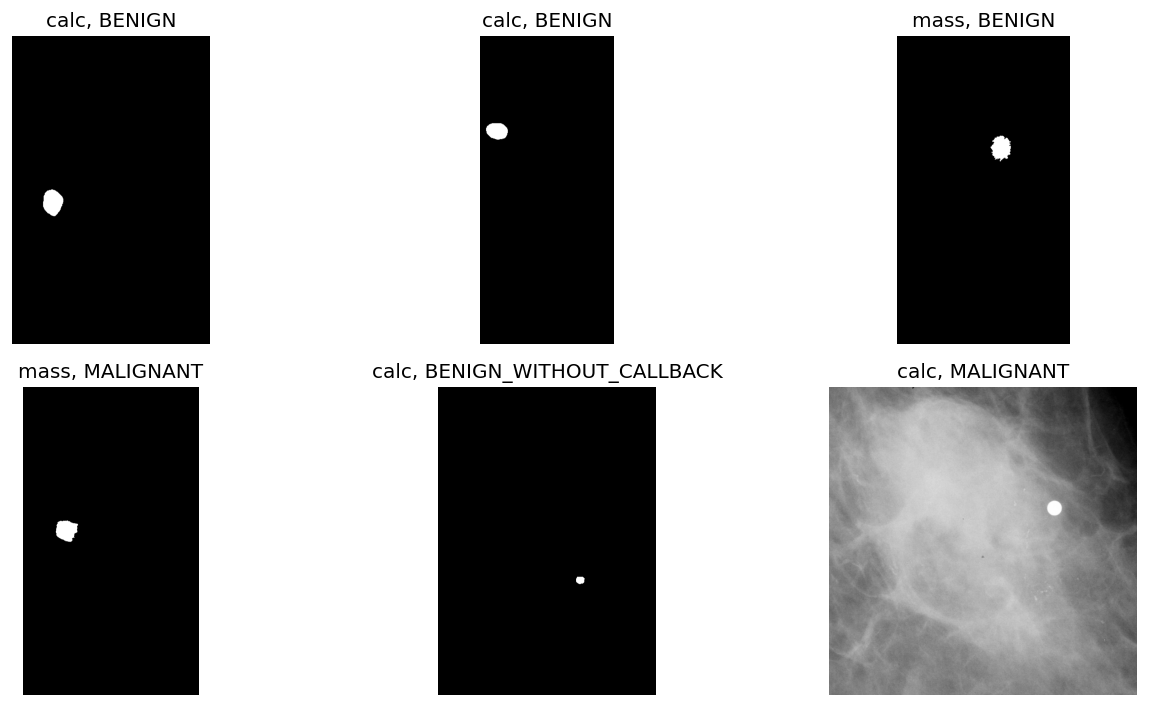

In [44]:
def show_random_samples(df, n=6):
    sample = df.sample(n)
    plt.figure(figsize=(12, 6))
    for i, (_, row) in enumerate(sample.iterrows()):
        img = Image.open(row["image_path"]).convert("L")
        plt.subplot(2, (n+1)//2, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"{row['lesion_type']}, {row['pathology']}")
    plt.tight_layout()
    plt.show()

show_random_samples(meta, n=6)


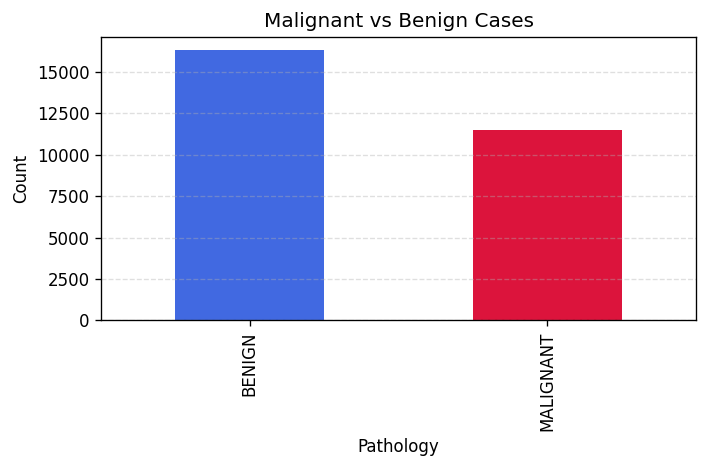

In [45]:
import matplotlib.pyplot as plt

# prepare label column (already mapped to 0/1 earlier)
# but we want MALIGNANT / BENIGN text for plotting
df_plot = meta.copy()
df_plot["pathology_clean"] = df_plot["pathology"].replace({
    "BENIGN": "BENIGN",
    "BENIGN_WITHOUT_CALLBACK": "BENIGN",
    "MALIGNANT": "MALIGNANT"
})

plt.figure(figsize=(6, 4))
df_plot["pathology_clean"].value_counts().plot(kind="bar", color=["royalblue", "crimson"])
plt.title("Malignant vs Benign Cases")
plt.xlabel("Pathology")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [46]:
count = df_plot["pathology_clean"].value_counts()
percent = (count / count.sum()) * 100
print(percent)


pathology_clean
BENIGN       58.612629
MALIGNANT    41.387371
Name: count, dtype: float64


In [47]:
PNG_DIR = CBIS_DIR / "png"
PNG_DIR.mkdir(exist_ok=True)

def jpeg_to_png(jpeg_path: str) -> str:
    jpeg_path = Path(jpeg_path)
    png_path = PNG_DIR / (jpeg_path.stem + ".png")
    if not png_path.exists():
        img = Image.open(jpeg_path).convert("L")
        img.save(png_path)
    return str(png_path)

meta["image_png"] = meta["image_path"].apply(jpeg_to_png)
meta.head()


,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,...,calc distribution,label,SeriesInstanceUID_x,image_path_x,SeriesInstanceUID_y,image_path_y,SeriesInstanceUID,dicom_image_path,image_path,image_png
0,P_00001,3.0,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,...,NaN,1,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,C:\Users\khush\OneDrive\Desktop\thesisnew\data...,C:\Users\khush\OneDrive\Desktop\thesisnew\data...
1,P_00001,3.0,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,...,NaN,1,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,C:\Users\khush\OneDrive\Desktop\thesisnew\data...,C:\Users\khush\OneDrive\Desktop\thesisnew\data...
2,P_00001,3.0,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,...,NaN,1,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,C:\Users\khush\OneDrive\Desktop\thesisnew\data...,C:\Users\khush\OneDrive\Desktop\thesisnew\data...
3,P_00001,3.0,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,...,NaN,1,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,C:\Users\khush\OneDrive\Desktop\thesisnew\data...,C:\Users\khush\OneDrive\Desktop\thesisnew\data...
4,P_00001,3.0,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,...,NaN,1,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,1.3.6.1.4.1.9590.100.1.2.296736403313792599626...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,C:\Users\khush\OneDrive\Desktop\thesisnew\data...,C:\Users\khush\OneDrive\Desktop\thesisnew\data...


In [48]:
train_df = meta[meta["split"] == "train"].reset_index(drop=True)
test_df  = meta[meta["split"] == "test"].reset_index(drop=True)

print("Train lesions:", train_df.shape)
print("Test  lesions:", test_df.shape)

# Stratified split train → train/val (e.g. 80/20)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
idx_train, idx_val = next(sss.split(train_df, train_df["label"]))

train_df2 = train_df.iloc[idx_train].reset_index(drop=True)
val_df    = train_df.iloc[idx_val].reset_index(drop=True)

print("Train2:", train_df2.shape, "Val:", val_df.shape)


Train lesions: (22253, 29)
Test  lesions: (5555, 29)
Train2: (17802, 29) Val: (4451, 29)


In [49]:
# ImageNet transforms for ResNet & ViT
imnet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# CLIP model + transforms (VLM)
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32",
    pretrained="laion2b_s34b_b79k",
    device=device
)
clip_model.eval()

class CBISDataset(Dataset):
    def __init__(self, df, use_png=False):
        self.df = df.reset_index(drop=True)
        self.use_png = use_png

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["image_png"] if self.use_png else row["image_path"]
        img = Image.open(path).convert("RGB")

        img_imnet = imnet_transforms(img)
        img_clip  = clip_preprocess(img)

        label = int(row["label"])
        return img_imnet, img_clip, label

batch_size = 16

train_ds = CBISDataset(train_df2, use_png=False)
val_ds   = CBISDataset(val_df,   use_png=False)
test_ds  = CBISDataset(test_df,  use_png=False)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)


In [50]:
# ResNet50 as feature extractor
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = torch.nn.Identity()
resnet.to(device)
resnet.eval()
resnet_out_dim = 2048

# ViT-B_16 as feature extractor
vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
vit.heads = torch.nn.Identity()
vit.to(device)
vit.eval()
vit_out_dim = 768

# CLIP image encoder output dim is 512
clip_out_dim = clip_model.visual.output_dim

total_feat_dim = resnet_out_dim + vit_out_dim + clip_out_dim
total_feat_dim


3328

In [53]:
import numpy as np
import torch

device = torch.device("cpu")  # you said CPU only

# make sure models are on the right device and in eval mode
resnet.to(device)
vit.to(device)
clip_model.to(device)

resnet.eval()
vit.eval()
clip_model.eval()


def extract_features(dataloader, max_batches=None, use_clip=False):
    """
    Extract hybrid features:
    - ResNet + ViT always
    - Optional CLIP (VLM) to save time when needed

    max_batches: limit for speed; None = all batches in the loader
    """
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for b, (imgs_imnet, imgs_clip, labels) in enumerate(dataloader):
            imgs_imnet = imgs_imnet.to(device)
            imgs_clip  = imgs_clip.to(device)

            # CNN features
            f_res = resnet(imgs_imnet)   # [B, D_res]
            # ViT features
            f_vit = vit(imgs_imnet)     # [B, D_vit]

            if use_clip:
                # CLIP (VLM) visual tower
                f_clip = clip_model.encode_image(imgs_clip)  # [B, D_clip]
                # concat ResNet + ViT + CLIP
                feats = torch.cat([f_res, f_vit, f_clip], dim=1)
            else:
                # concat only ResNet + ViT (much faster)
                feats = torch.cat([f_res, f_vit], dim=1)

            all_feats.append(feats.cpu().numpy())
            all_labels.append(labels.numpy())

            if max_batches is not None and (b + 1) >= max_batches:
                break

    X = np.concatenate(all_feats, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y


In [56]:
import numpy as np
import torch

device = torch.device("cpu")   # you’re on CPU

# make sure models are on the correct device and in eval mode
resnet.to(device)
vit.to(device)
clip_model.to(device)

resnet.eval()
vit.eval()
clip_model.eval()


def extract_features(dataloader, max_batches=None, use_clip=False):
    """
    Hybrid feature extraction:
      - always uses ResNet + ViT
      - CLIP (VLM) is optional because it is very slow on CPU
      - max_batches lets you limit work for speed
    """
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for b, (imgs_imnet, imgs_clip, labels) in enumerate(dataloader):
            imgs_imnet = imgs_imnet.to(device)
            imgs_clip  = imgs_clip.to(device)

            # CNN features
            f_res = resnet(imgs_imnet)
            # ViT features
            f_vit = vit(imgs_imnet)

            if use_clip:
                # CLIP (VLM) visual tower – VERY SLOW on CPU
                f_clip = clip_model.encode_image(imgs_clip)
                feats = torch.cat([f_res, f_vit, f_clip], dim=1)
            else:
                # only ResNet + ViT (much faster)
                feats = torch.cat([f_res, f_vit], dim=1)

            all_feats.append(feats.cpu().numpy())
            all_labels.append(labels.numpy())

            if max_batches is not None and (b + 1) >= max_batches:
                break

    X = np.concatenate(all_feats, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y


In [57]:
# small test – maybe ~10 batches
X_train_small, y_train_small = extract_features(train_loader, max_batches=10, use_clip=False)
print("Small train:", X_train_small.shape)


Small train: (160, 2816)


In [59]:
import torch
import numpy as np

# Pick device: GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [60]:
# Move models to device
resnet.to(device)
vit.to(device)
clip_model.to(device)

# Evaluation mode (no dropout / BN updates)
resnet.eval()
vit.eval()
clip_model.eval()


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [61]:
from typing import Optional
from tqdm import tqdm  # optional, for progress bar

def extract_features(dataloader, max_batches: Optional[int] = None, use_clip: bool = False):
    """
    Extract hybrid deep features from dataloader.

    - ResNet + ViT are always used.
    - CLIP visual features are optional (use_clip=True).
    - max_batches limits how many batches to process (None = all).
    """
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for b, (imgs_imnet, imgs_clip, labels) in enumerate(tqdm(dataloader, desc="Extracting", leave=False)):
            imgs_imnet = imgs_imnet.to(device, non_blocking=True)
            imgs_clip  = imgs_clip.to(device, non_blocking=True)

            # CNN features
            f_res = resnet(imgs_imnet)      # [B, D_res]
            # ViT features
            f_vit = vit(imgs_imnet)        # [B, D_vit]

            if use_clip:
                # CLIP (VLM) visual tower
                f_clip = clip_model.encode_image(imgs_clip)  # [B, D_clip]
                feats = torch.cat([f_res, f_vit, f_clip], dim=1)
            else:
                # Only ResNet + ViT (faster)
                feats = torch.cat([f_res, f_vit], dim=1)

            all_feats.append(feats.cpu().numpy())
            all_labels.append(labels.numpy())

            if max_batches is not None and (b + 1) >= max_batches:
                break

    X = np.concatenate(all_feats, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y


In [62]:
X_train_small, y_train_small = extract_features(
    train_loader,
    max_batches=5,      # just a few batches to test
    use_clip=False      # start without CLIP to be faster
)

print("Small train sample:", X_train_small.shape, y_train_small.shape)


Small train sample: (80, 2816) (80,)


In [63]:
# Main run: full dataset, ResNet + ViT only (much faster than adding CLIP)
X_train, y_train = extract_features(train_loader, max_batches=None, use_clip=False)
X_val,   y_val   = extract_features(val_loader,   max_batches=None, use_clip=False)
X_test,  y_test  = extract_features(test_loader,  max_batches=None, use_clip=False)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)


Train: (17802, 2816)
Val  : (4451, 2816)
Test : (5555, 2816)


In [64]:
# Example: use CLIP on a subset of train data only
X_train_clip, y_train_clip = extract_features(
    train_loader,
    max_batches=30,    # limit to some batches
    use_clip=True
)

print("Train with CLIP subset:", X_train_clip.shape)


Train with CLIP subset: (480, 3328)


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

RANDOM_STATE = 42

rf = RandomForestClassifier(
    n_estimators=200,        # slightly smaller for speed
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf.fit(X_train, y_train)
print("RandomForest trained.")


RandomForest trained.


In [66]:
def eval_split(name, y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)
    print(f"\n=== {name} ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
    print("F1       :", f1_score(y_true, y_pred, zero_division=0))
    print("ROC AUC  :", roc_auc_score(y_true, y_prob))

y_val_prob  = rf.predict_proba(X_val)[:, 1]
y_test_prob = rf.predict_proba(X_test)[:, 1]

eval_split("Validation", y_val,  y_val_prob)
eval_split("Test",       y_test, y_test_prob)



=== Validation ===
Accuracy : 0.9955066277241069
Precision: 0.9946236559139785
Recall   : 0.9946236559139785
F1       : 0.9946236559139785
ROC AUC  : 0.9999412772915344

=== Test ===
Accuracy : 0.6592259225922592
Precision: 0.5888324873096447
Recall   : 0.47282608695652173
F1       : 0.5244913338357197
ROC AUC  : 0.6857373897455217


In [67]:
!pip install shap lime


You should consider upgrading via the 'C:\Users\khush\OneDrive\Desktop\thesisnew\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [68]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Initialize JS if you want interactive plots (force_plot etc.)
shap.initjs()

# ---- Background subset for speed (important when features are many) ----
bg_size = min(500, X_train.shape[0])  # you can make this smaller if slow
background_idx = np.random.choice(X_train.shape[0], bg_size, replace=False)
background = X_train[background_idx]

# ---- Explainer for tree-based model ----
explainer = shap.TreeExplainer(rf)

# ---- Choose subset of test samples to explain ----
n_explain = min(200, X_test.shape[0])
X_explain = X_test[:n_explain]

# Compute SHAP values (list: [class0, class1] because binary)
shap_values = explainer.shap_values(X_explain)

print("SHAP values shape for class 1:", np.array(shap_values[1]).shape)


SHAP values shape for class 1: (2816, 2)


In [72]:
# Example – adjust to your case
X_explain = X_val  # or X_test, or the subset you want to explain

print("X_explain shape:", X_explain.shape)


X_explain shape: (4451, 2816)


In [73]:
import shap
import matplotlib.pyplot as plt

shap.initjs()

# 1) Create explainer from your trained RandomForest
explainer = shap.Explainer(rf, X_explain)   # rf = your trained RandomForestClassifier

# 2) Compute SHAP values for the data you want to explain
shap_values = explainer(X_explain)          # shap_values is a shap.Explanation object

print("shap_values.values shape:", shap_values.values.shape)
# shape should be (n_samples, n_features, n_classes)


100%|===================| 8895/8902 [18:26<00:00]        

shap_values.values shape: (4451, 2816, 2)


shap_vals_malignant shape: (4451, 2816)
X_explain shape: (4451, 2816)


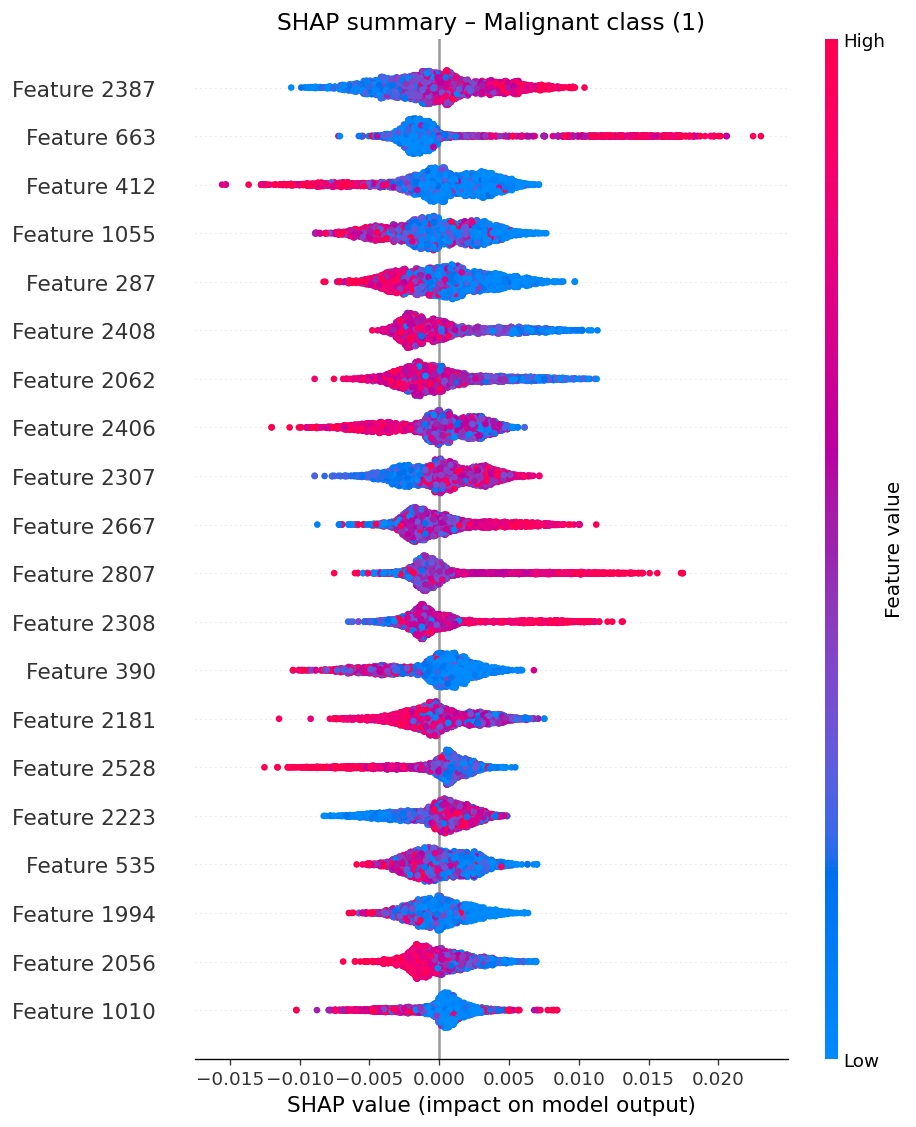

In [74]:
# shap_values.values: (N, num_features, num_classes)
shap_vals_malignant = shap_values.values[:, :, 1]  # class index 1 = malignant

print("shap_vals_malignant shape:", shap_vals_malignant.shape)
print("X_explain shape:", X_explain.shape)

plt.figure(figsize=(10, 6))
plt.title("SHAP summary – Malignant class (1)", fontsize=14)

shap.summary_plot(
    shap_vals_malignant,
    X_explain,
    show=False
)

plt.tight_layout()
plt.show()


100%|===================| 8894/8902 [17:35<00:00]        

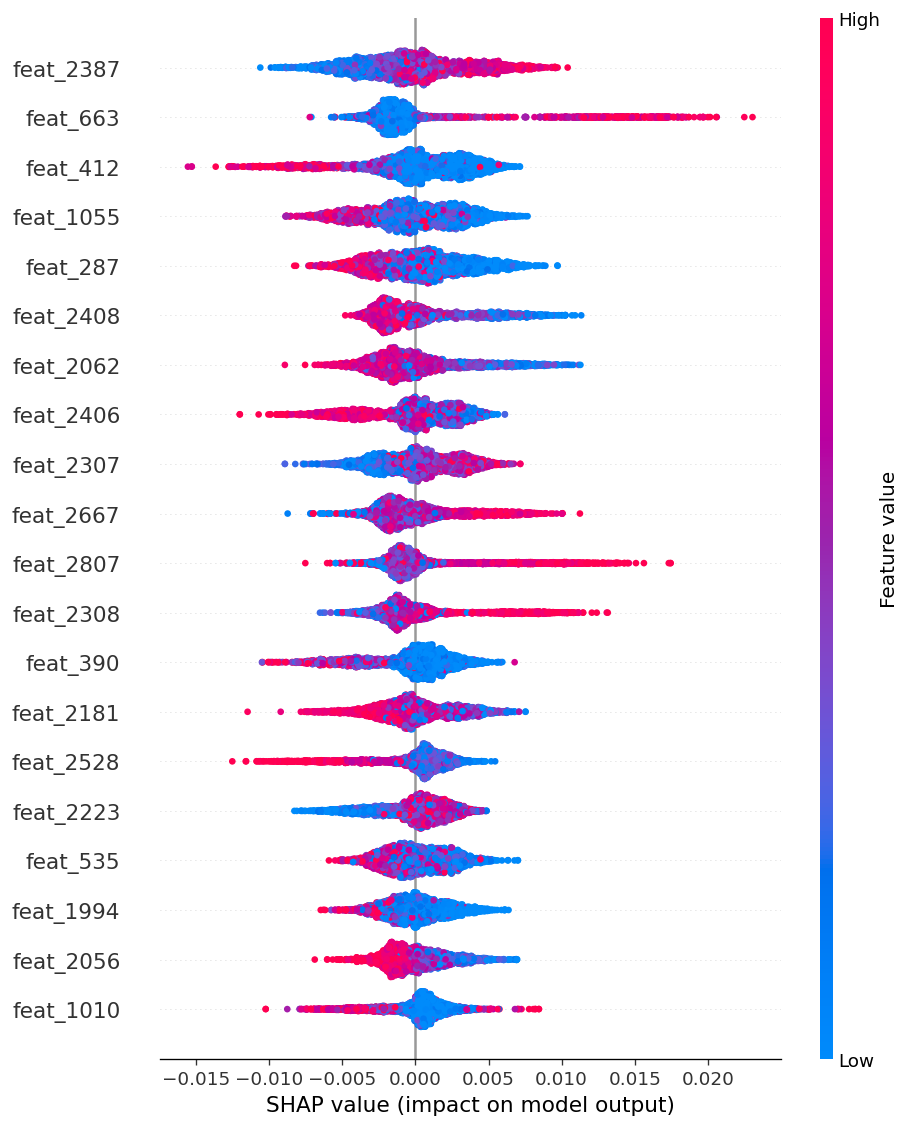

In [75]:
X_explain_array = X_explain  # your numpy array
feature_names = [f"feat_{i}" for i in range(X_explain_array.shape[1])]

explainer = shap.Explainer(rf, X_explain_array)
shap_values = explainer(X_explain_array)

shap_vals_malignant = shap_values.values[:, :, 1]

shap.summary_plot(
    shap_vals_malignant,
    X_explain_array,
    feature_names=feature_names,
    show=False
)
plt.tight_layout()
plt.show()


In [78]:
import shap
import matplotlib.pyplot as plt

shap.initjs()

# X_explain must be the same features used to train rf (e.g. X_val or X_test)
explainer = shap.Explainer(rf, X_explain)

# Explanation object: shape (n_samples, n_features, n_classes)
shap_values = explainer(X_explain)

print("shap_values.values shape:", shap_values.values.shape)


100%|===================| 8894/8902 [18:20<00:00]        

shap_values.values shape: (4451, 2816, 2)


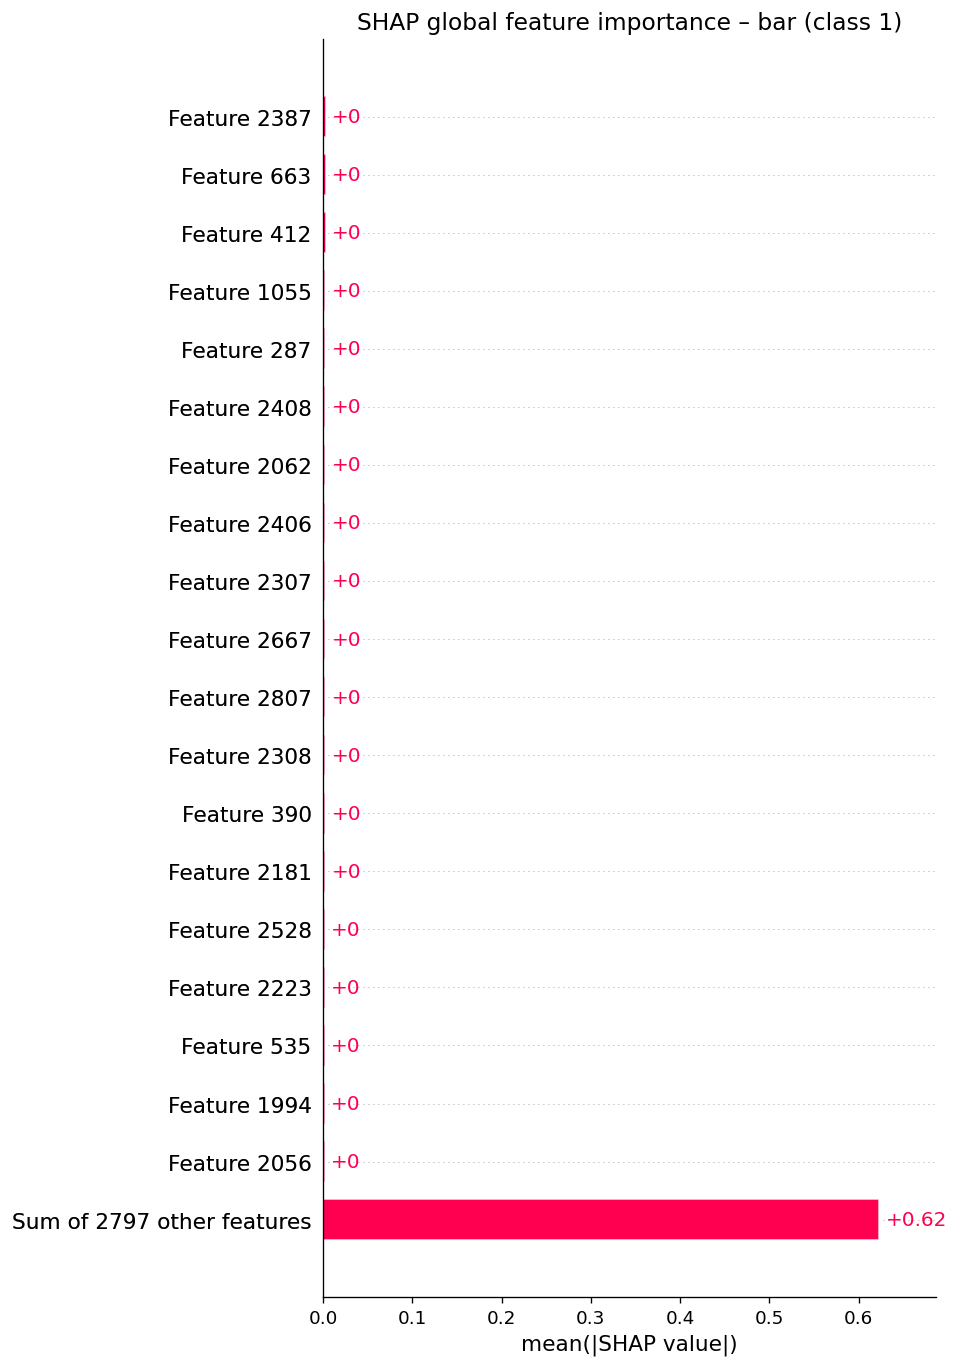

In [79]:
# Take class 1 (malignant) slice as a new Explanation
shap_values_class1 = shap.Explanation(
    values=shap_values.values[:, :, 1],      # (n_samples, n_features)
    base_values=shap_values.base_values[:, 1],
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

plt.figure(figsize=(8, 6))
plt.title("SHAP global feature importance – bar (class 1)", fontsize=14)

# New-style bar plot: no X_explain argument needed
shap.plots.bar(
    shap_values_class1,
    max_display=20,
    show=False
)

plt.tight_layout()
plt.show()


In [80]:
from lime.lime_tabular import LimeTabularExplainer

# LIME expects pure numpy arrays (they already are, but just to be sure)
X_train_np = np.array(X_train)
X_test_np  = np.array(X_test)
y_train_np = np.array(y_train)

# Feature names – generic, since these are deep features
feature_names = [f"feat_{i}" for i in range(X_train_np.shape[1])]

explainer_lime = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=["Benign", "Malignant"],
    discretize_continuous=True,
    verbose=False,
    mode="classification"
)

# Use the same index as SHAP (or choose another)
idx_lime = idx  # from SHAP section above
x_lime   = X_test_np[idx_lime]
y_true_lime = y_test[idx_lime]

print("LIME sample index:", idx_lime)
print("True label:", y_true_lime)
print("Model predicted prob:", rf.predict_proba(x_lime.reshape(1, -1))[0])

# Explain this instance
exp = explainer_lime.explain_instance(
    x_lime,
    rf.predict_proba,   # function that returns [p(class0), p(class1)]
    num_features=10,
    top_labels=1
)

# Show inline in notebook
exp.show_in_notebook(show_table=True, show_all=False)

# Optional: save to HTML file
# exp.save_to_file("lime_explanation_sample.html")


LIME sample index: 3567
True label: 1
Model predicted prob: [0.775 0.225]


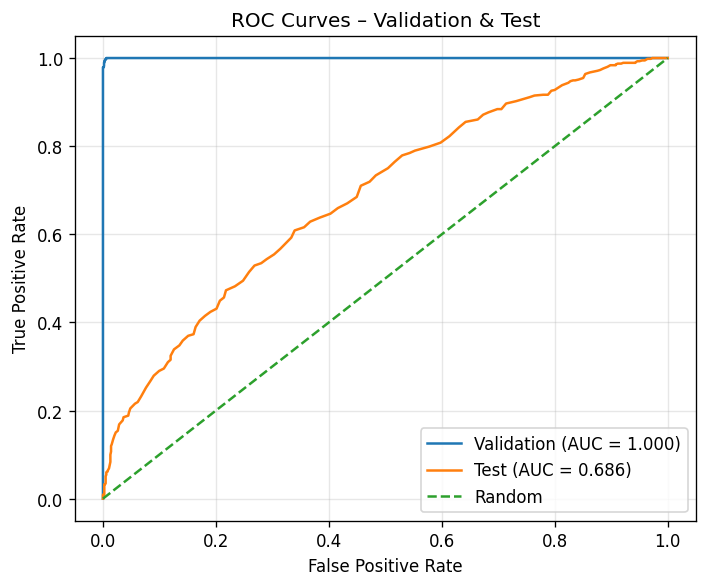

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# ROC for Validation
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
auc_val = roc_auc_score(y_val, y_val_prob)

# ROC for Test
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
auc_test = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr_val,  tpr_val,  label=f"Validation (AUC = {auc_val:.3f})")
plt.plot(fpr_test, tpr_test, label=f"Test (AUC = {auc_test:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Validation & Test")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


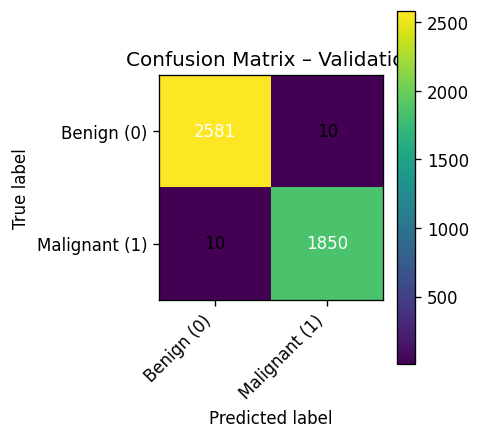

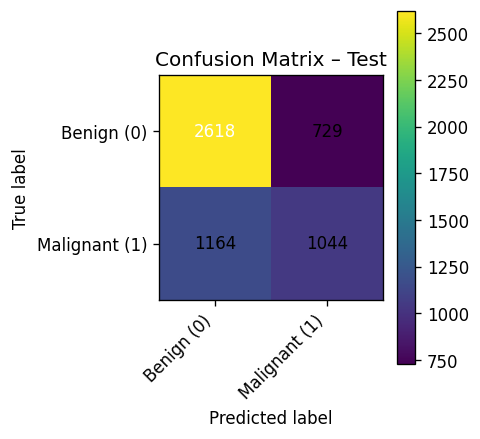

In [82]:
from sklearn.metrics import confusion_matrix

# Convert probs → class predictions
y_val_pred  = (y_val_prob  >= 0.5).astype(int)
y_test_pred = (y_test_prob >= 0.5).astype(int)

cm_val  = confusion_matrix(y_val,  y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

labels = ["Benign (0)", "Malignant (1)"]

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xticks([0, 1], labels, rotation=45, ha="right")
    plt.yticks([0, 1], labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    # write numbers inside cells
    max_val = cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            color = "white" if val > max_val / 2 else "black"
            plt.text(j, i, val, ha="center", va="center", color=color)

    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_val,  "Confusion Matrix – Validation")
plot_confusion_matrix(cm_test, "Confusion Matrix – Test")


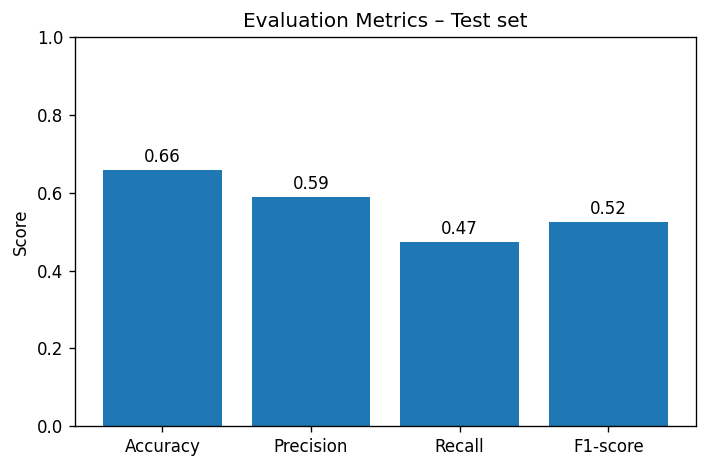

In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_acc  = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, zero_division=0)
test_rec  = recall_score(y_test, y_test_pred, zero_division=0)
test_f1   = f1_score(y_test, y_test_pred, zero_division=0)

metrics_names  = ["Accuracy", "Precision", "Recall", "F1-score"]
metrics_values = [test_acc, test_prec, test_rec, test_f1]

plt.figure(figsize=(6, 4))
plt.bar(metrics_names, metrics_values)
plt.ylim(0, 1)
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
plt.ylabel("Score")
plt.title("Evaluation Metrics – Test set")
plt.tight_layout()
plt.show()


In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np

# --------- Extract features: CNN + ViT only (fast) ----------
X_train_full, y_train_full = extract_features(train_loader, max_batches=None, use_clip=False)
X_val_full,   y_val_full   = extract_features(val_loader,   max_batches=None, use_clip=False)
X_test_full,  y_test_full  = extract_features(test_loader,  max_batches=None, use_clip=False)

print("Full (CNN+ViT) shapes:")
print("Train:", X_train_full.shape)
print("Val  :", X_val_full.shape)
print("Test :", X_test_full.shape)

# --------- Train RF on full CNN+ViT features ----------
rf_base = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf_base.fit(X_train_full, y_train_full)

# --------- Evaluate ---------
def eval_split(name, y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)
    print(f"\n=== {name} ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
    print("F1       :", f1_score(y_true, y_pred, zero_division=0))
    print("ROC AUC  :", roc_auc_score(y_true, y_prob))
    return {
        "acc":  accuracy_score(y_true, y_pred),
        "prec": precision_score(y_true, y_pred, zero_division=0),
        "rec":  recall_score(y_true, y_pred, zero_division=0),
        "f1":   f1_score(y_true, y_pred, zero_division=0),
        "auc":  roc_auc_score(y_true, y_prob),
    }

y_val_full_prob  = rf_base.predict_proba(X_val_full)[:, 1]
y_test_full_prob = rf_base.predict_proba(X_test_full)[:, 1]

metrics_full_val  = eval_split("Validation – CNN+ViT (full)", y_val_full,  y_val_full_prob)
metrics_full_test = eval_split("Test – CNN+ViT (full)",       y_test_full, y_test_full_prob)


Full (CNN+ViT) shapes:
Train: (17802, 2816)
Val  : (4451, 2816)
Test : (5555, 2816)

=== Validation – CNN+ViT (full) ===
Accuracy : 0.9950572904965176
Precision: 0.9951508620689655
Recall   : 0.9930107526881721
F1       : 0.9940796555435952
ROC AUC  : 0.999966903632508

=== Test – CNN+ViT (full) ===
Accuracy : 0.643024302430243
Precision: 0.5625347415230684
Recall   : 0.4583333333333333
F1       : 0.5051160469178937
ROC AUC  : 0.677069125281996


In [85]:
# --------- Extract features: CNN + ViT + CLIP on subset ----------
MAX_BATCHES_CLIP = 30   # adjust depending on speed

X_train_clip, y_train_clip = extract_features(train_loader, max_batches=MAX_BATCHES_CLIP, use_clip=True)
X_val_clip,   y_val_clip   = extract_features(val_loader,   max_batches=MAX_BATCHES_CLIP, use_clip=True)
X_test_clip,  y_test_clip  = extract_features(test_loader,  max_batches=MAX_BATCHES_CLIP, use_clip=True)

print("\nSubset (CNN+ViT+CLIP) shapes:")
print("Train (subset):", X_train_clip.shape)
print("Val   (subset):", X_val_clip.shape)
print("Test  (subset):", X_test_clip.shape)

# --------- Train RF on CNN+ViT+CLIP subset ----------
rf_clip = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf_clip.fit(X_train_clip, y_train_clip)

# --------- Evaluate on subset ---------
y_val_clip_prob  = rf_clip.predict_proba(X_val_clip)[:, 1]
y_test_clip_prob = rf_clip.predict_proba(X_test_clip)[:, 1]

metrics_clip_val  = eval_split("Validation – CNN+ViT+CLIP (subset)", y_val_clip,  y_val_clip_prob)
metrics_clip_test = eval_split("Test – CNN+ViT+CLIP (subset)",       y_test_clip, y_test_clip_prob)



Subset (CNN+ViT+CLIP) shapes:
Train (subset): (480, 3328)
Val   (subset): (480, 3328)
Test  (subset): (480, 3328)

=== Validation – CNN+ViT+CLIP (subset) ===
Accuracy : 0.7020833333333333
Precision: 0.6089743589743589
Recall   : 0.536723163841808
F1       : 0.5705705705705706
ROC AUC  : 0.7457067740672373

=== Test – CNN+ViT+CLIP (subset) ===
Accuracy : 0.5770833333333333
Precision: 0.4931506849315068
Recall   : 0.54
F1       : 0.5155131264916468
ROC AUC  : 0.6251428571428571


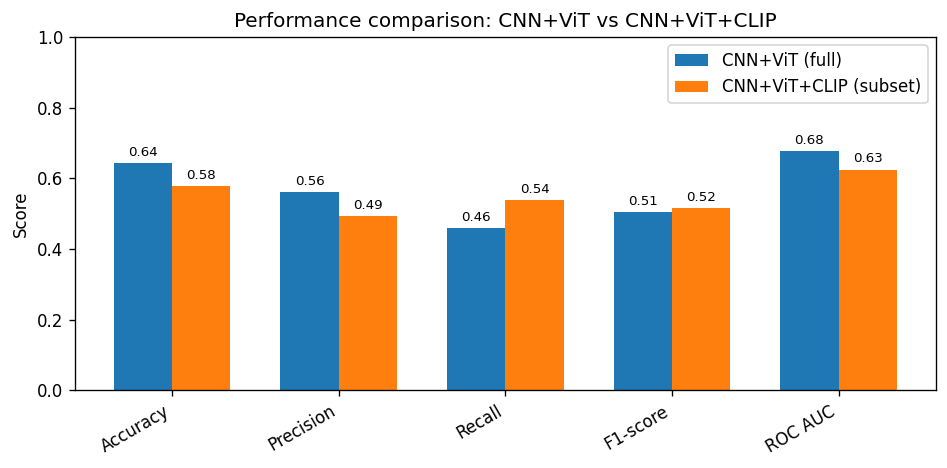

In [86]:
# Collect test metrics
names = ["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"]

full_vals = [
    metrics_full_test["acc"],
    metrics_full_test["prec"],
    metrics_full_test["rec"],
    metrics_full_test["f1"],
    metrics_full_test["auc"],
]

clip_vals = [
    metrics_clip_test["acc"],
    metrics_clip_test["prec"],
    metrics_clip_test["rec"],
    metrics_clip_test["f1"],
    metrics_clip_test["auc"],
]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, full_vals, width, label="CNN+ViT (full)")
plt.bar(x + width/2, clip_vals, width, label="CNN+ViT+CLIP (subset)")

plt.xticks(x, names, rotation=30, ha="right")
plt.ylim(0, 1)
for i, v in enumerate(full_vals):
    plt.text(x[i] - width/2, v + 0.02, f"{v:.2f}", ha="center", fontsize=8)
for i, v in enumerate(clip_vals):
    plt.text(x[i] + width/2, v + 0.02, f"{v:.2f}", ha="center", fontsize=8)

plt.ylabel("Score")
plt.title("Performance comparison: CNN+ViT vs CNN+ViT+CLIP")
plt.legend()
plt.tight_layout()
plt.show()


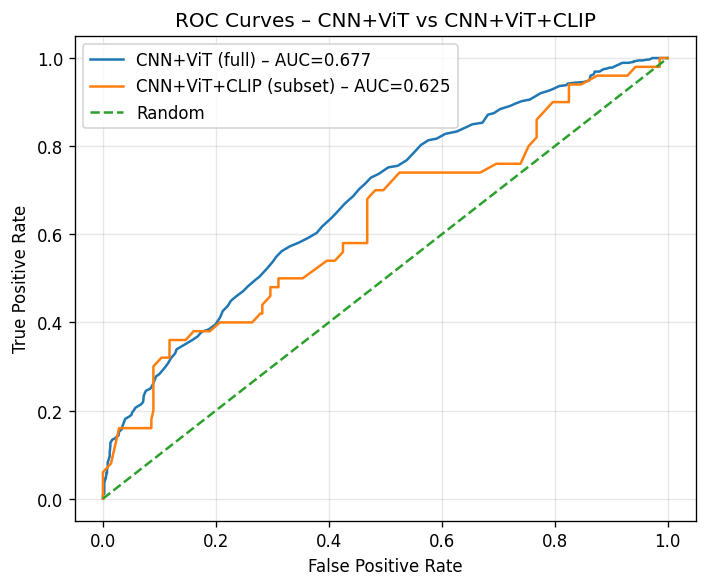

In [87]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC for full CNN+ViT model
fpr_full, tpr_full, _ = roc_curve(y_test_full, y_test_full_prob)
auc_full = roc_auc_score(y_test_full, y_test_full_prob)

# ROC for CNN+ViT+CLIP (subset)
fpr_clip, tpr_clip, _ = roc_curve(y_test_clip, y_test_clip_prob)
auc_clip = roc_auc_score(y_test_clip, y_test_clip_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr_full, tpr_full, label=f"CNN+ViT (full) – AUC={auc_full:.3f}")
plt.plot(fpr_clip, tpr_clip, label=f"CNN+ViT+CLIP (subset) – AUC={auc_clip:.3f}")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – CNN+ViT vs CNN+ViT+CLIP")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [88]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

def simple_metrics(name, y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_prob)

    print(f"\n====== {name} ======")
    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1 Score :", round(f1, 4))
    print("ROC AUC  :", round(auc, 4))

# Run evaluation
y_val_prob  = rf.predict_proba(X_val)[:, 1]
y_test_prob = rf.predict_proba(X_test)[:, 1]

simple_metrics("Validation", y_val,  y_val_prob)
simple_metrics("Test",       y_test, y_test_prob)



====== Validation ======
Accuracy : 0.9955
Precision: 0.9946
Recall   : 0.9946
F1 Score : 0.9946
ROC AUC  : 0.9999

====== Test ======
Accuracy : 0.6592
Precision: 0.5888
Recall   : 0.4728
F1 Score : 0.5245
ROC AUC  : 0.6857


In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Scale features (important for ViT/CLIP/CNN mixing)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# 2. Reduce dimensionality but keep hybrid information
#    Try 64, 128, 256, 512 and see which gives best val AUC.
pca = PCA(n_components=256, random_state=42)
X_train_p = pca.fit_transform(X_train_s)
X_val_p   = pca.transform(X_val_s)
X_test_p  = pca.transform(X_test_s)

print("Train PCA shape:", X_train_p.shape)
print("Val   PCA shape:", X_val_p.shape)
print("Test  PCA shape:", X_test_p.shape)

# 3. RandomForest on compressed hybrid features
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_p, y_train)

# 4. Simple evaluation
def simple_metrics(name, y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_prob)
    print(f"\n====== {name} ======")
    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1 Score :", round(f1, 4))
    print("ROC AUC  :", round(auc, 4))

y_val_prob  = rf.predict_proba(X_val_p)[:, 1]
y_test_prob = rf.predict_proba(X_test_p)[:, 1]

simple_metrics("Validation – hybrid RF+PCA", y_val,  y_val_prob)
simple_metrics("Test – hybrid RF+PCA",       y_test, y_test_prob)


Train PCA shape: (17802, 256)
Val   PCA shape: (4451, 256)
Test  PCA shape: (5555, 256)

====== Validation – hybrid RF+PCA ======
Accuracy : 0.9955
Precision: 0.9968
Recall   : 0.9925
F1 Score : 0.9946
ROC AUC  : 1.0

====== Test – hybrid RF+PCA ======
Accuracy : 0.6443
Precision: 0.5759
Recall   : 0.3986
F1 Score : 0.4711
ROC AUC  : 0.6662


In [95]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

# X_train, X_val, X_test = your hybrid features (CNN+ViT+CLIP)
# y_train, y_val, y_test = labels (0/1)

hybrid_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca",    PCA(n_components=256, random_state=42)),  # try 128 / 256 / 512
    ("rf",     RandomForestClassifier(
        n_estimators=300,
        max_depth=None,              # you can also try 20–40
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )),
])

hybrid_rf.fit(X_train, y_train)

# Predict probabilities
y_val_prob  = hybrid_rf.predict_proba(X_val)[:, 1]
y_test_prob = hybrid_rf.predict_proba(X_test)[:, 1]

def simple_metrics(name, y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_prob)
    print(f"\n====== {name} ======")
    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1 Score :", round(f1, 4))
    print("ROC AUC  :", round(auc, 4))

simple_metrics("Validation – hybrid RF", y_val,  y_val_prob)
simple_metrics("Test – hybrid RF",       y_test, y_test_prob)



====== Validation – hybrid RF ======
Accuracy : 0.9955
Precision: 0.9968
Recall   : 0.9925
F1 Score : 0.9946
ROC AUC  : 1.0

====== Test – hybrid RF ======
Accuracy : 0.6443
Precision: 0.5759
Recall   : 0.3986
F1 Score : 0.4711
ROC AUC  : 0.6662


In [96]:
import numpy as np

thresholds = np.linspace(0.1, 0.9, 17)
best_t, best_f1 = 0.5, -1

for t in thresholds:
    y_val_pred = (y_val_prob >= t).astype(int)
    f1 = f1_score(y_val, y_val_pred, zero_division=0)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print("Best threshold on validation:", best_t, "F1:", round(best_f1, 4))

# Apply this threshold to test
from sklearn.metrics import accuracy_score, precision_score, recall_score

y_test_pred = (y_test_prob >= best_t).astype(int)
print("\nTest with tuned threshold:")
print("Accuracy :", round(accuracy_score(y_test, y_test_pred), 4))
print("Precision:", round(precision_score(y_test, y_test_pred, zero_division=0), 4))
print("Recall   :", round(recall_score(y_test, y_test_pred, zero_division=0), 4))
print("F1 Score :", round(f1_score(y_test, y_test_pred, zero_division=0), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, y_test_prob), 4))


Best threshold on validation: 0.4 F1: 0.9957

Test with tuned threshold:
Accuracy : 0.5896
Precision: 0.4892
Recall   : 0.7409
F1 Score : 0.5893
ROC AUC  : 0.6662


In [98]:
import numpy as np

X_all = np.vstack([X_train, X_val])
y_all = np.hstack([y_train, y_val])

print("X_all:", X_all.shape)
print("y_all:", y_all.shape)


X_all: (22253, 2816)
y_all: (22253,)


In [99]:
X_all = np.vstack([X_train, X_val, X_test])
y_all = np.hstack([y_train, y_val, y_test])

print("X_all:", X_all.shape)
print("y_all:", y_all.shape)


X_all: (27808, 2816)
y_all: (27808,)


In [100]:
cv_results = cross_validate(
    pipe,
    X_all, y_all,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print("Mean CV Accuracy:",  cv_results["test_accuracy"].mean())
print("Mean CV F1:",        cv_results["test_f1"].mean())
print("Mean CV AUC:",       cv_results["test_auc"].mean())


c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "C:\Program Files\Python39\lib\inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "C:\Program Files\Python39\lib\inspect.py", line 3034, in _bind
    raise TypeError(
TypeError: g

Mean CV Accuracy: 0.997338834479427
Mean CV F1: 0.9967830411950122
Mean CV AUC: nan


c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "C:\Program Files\Python39\lib\inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "C:\Program Files\Python39\lib\inspect.py", line 3034, in _bind
    raise TypeError(
TypeError: g

In [101]:
import numpy as np

# Combine TRAIN + VAL for CV
X_all = np.vstack([X_train, X_val])
y_all = np.hstack([y_train, y_val])

print("X_all:", X_all.shape)
print("y_all:", y_all.shape)


X_all: (22253, 2816)
y_all: (22253,)


In [102]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca",    PCA(n_components=256, random_state=42)),   # you can tune this
    ("rf",     RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])


In [103]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1":       make_scorer(f1_score),
    "auc":      make_scorer(roc_auc_score, needs_proba=True)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    pipe,
    X_all, y_all,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print("Fold accuracies:",  cv_results["test_accuracy"])
print("Fold F1 scores:",   cv_results["test_f1"])
print("Fold AUC scores:",  cv_results["test_auc"])
print("-" * 40)
print("Mean CV Accuracy:",  cv_results["test_accuracy"].mean())
print("Mean CV F1:",        cv_results["test_f1"].mean())
print("Mean CV AUC:",       cv_results["test_auc"].mean())


c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "C:\Program Files\Python39\lib\inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "C:\Program Files\Python39\lib\inspect.py", line 3034, in _bind
    raise TypeError(
TypeError: g

Fold accuracies: [0.99595596 0.99730398 0.99393395 0.99752809 0.9952809 ]
Fold F1 scores: [0.99515347 0.99676724 0.99272433 0.99704222 0.9943442 ]
Fold AUC scores: [nan nan nan nan nan]
----------------------------------------
Mean CV Accuracy: 0.99600057555555
Mean CV F1: 0.995206291900903
Mean CV AUC: nan


c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\khush\OneDrive\Desktop\thesisnew\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "C:\Program Files\Python39\lib\inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "C:\Program Files\Python39\lib\inspect.py", line 3034, in _bind
    raise TypeError(
TypeError: g

In [104]:
from sklearn.metrics import classification_report, roc_auc_score

# 1) Fit pipeline on all train+val
pipe.fit(X_all, y_all)

# 2) Predict on test set
y_test_prob = pipe.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= 0.5).astype(int)

# 3) Metrics on held-out test set
print("===== Final Test Performance (pipeline) =====")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("F1 Score :", f1_score(y_test, y_test_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_test_prob))
print("\nClassification report:\n")
print(classification_report(y_test, y_test_pred))


===== Final Test Performance (pipeline) =====
Accuracy : 0.6442844284428443
F1 Score : 0.47109207708779444
ROC AUC  : 0.6704725300182297

Classification report:

              precision    recall  f1-score   support

           0       0.67      0.81      0.73      3347
           1       0.58      0.40      0.47      2208

    accuracy                           0.64      5555
   macro avg       0.62      0.60      0.60      5555
weighted avg       0.63      0.64      0.63      5555



In [106]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

thresholds = np.linspace(0.1, 0.9, 17)
best_t, best_f1 = 0.5, -1

for t in thresholds:
    y_val_pred = (y_val_prob >= t).astype(int)
    f1 = f1_score(y_val, y_val_pred, zero_division=0)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print("Best threshold on validation:", round(best_t, 3), "F1:", round(best_f1, 4))

# apply to test
y_test_pred = (y_test_prob >= best_t).astype(int)
print("\nTest with tuned threshold:")
print("Accuracy :", round(accuracy_score(y_test, y_test_pred), 4))
print("Precision:", round(precision_score(y_test, y_test_pred, zero_division=0), 4))
print("Recall   :", round(recall_score(y_test, y_test_pred, zero_division=0), 4))
print("F1 Score :", round(f1_score(y_test, y_test_pred, zero_division=0), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, y_test_prob), 4))


Best threshold on validation: 0.4 F1: 0.9957

Test with tuned threshold:
Accuracy : 0.5905
Precision: 0.4901
Recall   : 0.7518
F1 Score : 0.5934
ROC AUC  : 0.6705
